# YOLOV2 Scratch Two

In [1]:
import numpy as np
import mxnet as mx

from mxnet import nd
from mxnet import gluon
from mxnet import image
from mxnet import autograd

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['figure.figsize'] = (6, 6)
import matplotlib.pyplot as plt 

## 中心点转换

In [2]:
def transform_center(xy):
    '''
    Given x, y prediction after sigmoid(), convert to relative coordinates (0, 1) on image 
    '''
    b, h, w, n, s = xy.shape 
    
    offset_y = nd.tile(nd.arange(0, h, repeat=(w * n * 1), ctx=xy.context).reshape((1, h, w, n, 1)), (b, 1, 1, 1, 1))
    offset_x = nd.tile(nd.arange(0, w, repeat=(n * 1), ctx=xy.context).reshape((1, 1, w, n, 1)), (b, h, 1, 1, 1))
    
    x, y = xy.split(num_outputs=2, axis=-1)

    x = (x + offset_x) / w
    h = (h + offset_y) / h
    
    return x, y

## 长宽转换

In [3]:
def transform_size(wh, anchors):
    '''
    Given w, h prediction after exp() and anchor sizes, convert to relative width/height (0, 1) on image
    '''
    
    b, h, w, n, s = wh.shape
    
    aw, ah = nd.tile(nd.array(anchors, ctx=wh.context).reshape((1, 1, 1, -1, 2)), (b, h, w, 1, 1)).split(num_outputs=2, axis=-1)
    w_pred, h_pred = nd.exp(wh).split(num_outputs=2, axis=-1)
    
    w_out = w_pred * aw / w
    h_out = h_pred * ah / h

    return w_out, h_out

## YOLOV2前向函数，用于生成预测值

In [4]:
def yolov2_forward(x, num_classes, anchor_scales):
    channel_per_anchor = num_classes + 1 + 4
    
    x = x.transpose((0, 2, 3, 1)) # channel to the last axis
    x = x.reshape((0, 0, 0, -1, channel_per_anchor)) # batch X height X width X num_anchors X channel_per_anchors
    
    # class preds 
    cls_preds = x.slice_axis(begin=0, end=num_classes, axis=-1)
    
    # objectness score preds 
    score_preds = x.slice_axis(begin=num_classes, end=num_classes+1, axis=-1)
    score = nd.sigmoid(score_preds)
    
    # (x, y) center prediction
    xy_preds = x.slice_axis(begin=num_classes+1, end=num_classes+3, axis=-1)
    xy = nd.sigmoid(xy_preds)
    
    # height, width prediction 
    wh = x.slice_axis(begin=num_classes+3, end=num_classes+5, axis=-1)
    
    # transform w, h relative to the fm
    w, h = transform_size(wh=wh, anchors=anchor_scales)
    
    # transform center coordinate relative to the fm 
    x, y = transform_center(xy=xy)
    
    # this box belong to which cls
    cid = nd.argmax(cls_preds, axis=-1, keepdims=True)
    
    # convert to corner coordinates (xmin, ymin, xmax, ymax)
    half_w = w / 2
    half_h = h / 2
    left = nd.clip(x - half_w, 0, 1) # xmin 
    top = nd.clip(y - half_h, 0, 1) # ymin
    right = nd.clip(x + half_w, 0, 1) # xmax
    bottom = nd.clip(y + half_h, 0, 1) # ymax
    
    # concat to output 
    output = nd.concat(*[cid, score, left, top, right, bottom], dim=4)
    
    return output, cls_preds, score, nd.concat(*[xy, wh], dim=4)

## YOLOV2目标函数，用于生成真实值

这里应该是yolov2实现部分最难理解的一块

In [5]:
def yolov2_target(scores, labels, anchors, ignore_label=-1):
    '''
    Generating training targets given predictions and labels
    '''
    
    # n represnet the number of anchors
    b, h, w, n, _ = scores.shape 
    anchors = np.reshape(np.array(anchors), (-1, 2))
    
    # ground truth boxes 
    gt_boxes = nd.slice_axis(data=labels, begin=1, end=5, axis=-1) 
    
    target_score = nd.zeros((b, h, w, n, 1), ctx=scores.context)
    target_id = nd.ones_like(target_score, ctx=scores.context) * ignore_label
    target_box = nd.zeros((b, h, w, n, 4), ctx=scores.context)
    sample_weight = nd.zeros((b, h, w, n ,1), ctx=scores.context)
    
    # the number of batch size 
    for b in range(output.shape[0]):
        # find the best match for each ground truth 
        label = labels[b].asnumpy()
        valid_label = label[np.where(label[:, 0] > -0.5)[0], :]
        # shuffle because multi gt could possibly match to one anchor
        # we keep the best match
        np.random.shuffle(valid_label)
        for l in valid_label:
            gx, gy, gw, gh = (l[1]+l[3])/2, (l[2]+l[4])/2, l[3]-l[1], l[4]-l[2]
            ind_x = int(gx * w) # make the gx in (0,1) to the w scale 
            ind_y = int(gy * h) # make the gy in (0,1) to the h scale 
            
            tx = gx * w - ind_x # the offset_x each grid point e.g. 150.2 - 150
            ty = gy * h - ind_y # the offset_y each grid point e.g. 150.2 - 150
            gw = gw * w #  make the gw in (0,1) to the w scale 
            gh = gh * h #  make the gh in (0,1) to the h scale 
            
            # find the best match using width and height only, assuming centers are identical
            intersect = np.minimum(anchors[:, 0], gw) * np.minimum(anchors[:, 1], gh)
            overlaps = intersect / (gw * gh + anchors[:, 0] * anchors[:, 1] - intersect)
            best_match = int(np.argmax(overlaps)) # find best_match
            
            target_id[b, ind_y, ind_x, best_match, :] = l[0]
            target_score[b, ind_y, ind_x, best_match, :] = 1.0
            
            tw = np.log(gw / anchors[best_match, 0])
            th = np.log(gh / anchors[best_match, 1])
            
            target_box[b, ind_y, ind_x, best_match, :] = nd.array([tx, ty, tw, th])
            
            sample_weight[b, ind_y, ind_x, best_match, :] = 1.0
    
    return target_id, target_score, target_box, sample_weight

## YOLOV2主体网络

In [6]:
from mxnet.gluon.model_zoo import vision

# output model act as output layer 
class YOLOV2Output(gluon.nn.HybridBlock):
    def __init__(self, num_class, anchor_scales, **kwargs):
        super().__init__(**kwargs)
        assert num_class > 0, "number of classes should > 0, given {}.".format(num_class)
        self._num_class = num_class
        assert isinstance(anchor_scales, (list, tuple)), "list or tuple of anchor scales required."
        assert len(anchor_scales) > 0, "at least one anchor scale required."
        for anchor in anchor_scales:
            assert len(anchor) == 2, "expected each anchor scale to be (width, height), provided {}.".format(anchor)
        self._anchor_scales = anchor_scales
        out_channels = len(anchor_scales) * (num_class + 1 + 4)
        with self.name_scope():
            self.output = gluon.nn.Conv2D(out_channels, kernel_size=1, strides=1)
            
    def hybrid_forward(self, F, X):
        return self.output(X)

# pretrained model act as feature extractor
pretrained = vision.get_model('resnet18_v1', pretrained=True).features
net = gluon.nn.HybridSequential()
for i in range(len(pretrained) - 2):
    net.add(pretrained[i])

scales = [[3.3004, 3.59034],
          [9.84923, 8.23783]]
    
yolov2_output = YOLOV2Output(num_class=2, anchor_scales=scales)
yolov2_output.initialize()
net.add(yolov2_output)

## 损失和评估函数

In [7]:
sce_loss = gluon.loss.SoftmaxCrossEntropyLoss()
l1_loss = gluon.loss.L1Loss()

In [8]:
from mxnet import metric

class LossRecorder(metric.EvalMetric):
    '''
    LossRecorder is used to reocrd raw loss so we can observe loss directly 
    '''
    def __init__(self, name):
        super(LossRecorder, self).__init__(name)
    
    def update(self, labels, preds=0):
        '''Update metric with pure loss'''
        for loss in labels:
            if isinstance(loss, nd.NDArray):
                loss = loss.asnumpy()
            self.sum_metric += loss.sum()
            self.num_inst += 1
            
obj_loss = LossRecorder('objectness_loss')
cls_loss = LossRecorder('classification_loss')
box_loss = LossRecorder('box_refine_loss')

# 粗粒度调控下每种损失相对的权重
positive_weight = 5.0
negative_weight = 0.1
class_weight = 1.0
box_weight = 5.0

## 下载和加载数据集

In [9]:
root_url = ('https://apache-mxnet.s3-accelerate.amazonaws.com/'
            'gluon/dataset/pikachu/')
data_dir = 'data/pikachu/'
dataset = {'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8',
          'train.idx': 'dcf7318b2602c06428b9988470c731621716c393',
          'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'}

for k, v in dataset.items():
    gluon.utils.download(url=root_url + k, path=data_dir + k, sha1_hash=v)

In [10]:
data_shape = 256 
batch_size = 64

rgb_mean = nd.array([123, 117, 104])
rgb_std = nd.array([58.395, 57.12, 57.375])

def get_iterators(data_shape, batch_size):
    class_names = ['pikachu', 'dummy']
    num_class = len(class_names)
    
    train_iter = image.ImageDetIter(batch_size=batch_size, 
                                    data_shape=(3, data_shape, data_shape),
                                    path_imgrec=data_dir+'train.rec', 
                                    path_imgidx=data_dir+'train.idx',
                                    shuffle=True, 
                                    mean=True,
                                    std=True,
                                    rand_crop=1,
                                    min_object_covered=0.95,
                                    max_attempts=200)
    
    valid_iter = image.ImageDetIter(batch_size=batch_size,
                                    data_shape=(3, data_shape, data_shape),
                                    path_imgrec=data_dir+'val.rec',
                                    shuffle=False,
                                    mean=True, 
                                    std=True)
    
    return train_iter, valid_iter, class_names, num_class

train_data, valid_data, class_names, num_class = get_iterators(data_shape=data_shape, batch_size=batch_size)

## 画出数据集

In [11]:
def box_to_rect(box, color, linewidth=3):
    '''convert an box to matplotlib Rectangle'''
    box = box.asnumpy()
    return plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], 
                         fill=False, edgecolor=color, linewidth=linewidth)

In [12]:
def show_images(batch, nrows, ncols):
    _, figs = plt.subplots(nrows, ncols, figsize=(6, 6))
    for i in range(nrows):
        for j in range(ncols):
            img, labels = batch.data[0][i * nrows + j], batch.label[0][i * nrows + j]
            img = img.transpose((1, 2, 0)) * rgb_std + rgb_mean
            img = img.clip(0, 255).asnumpy() / 255
            fig = figs[i][j]
            fig.imshow(img)
            
            for label in labels:
                rect = box_to_rect(label[1:5] * data_shape, 'red', 2)
                fig.add_patch(rect)
            
            fig.axes.get_xaxis().set_visible(False)
            fig.axes.get_yaxis().set_visible(False)
            
    plt.show()

In [13]:
batch = train_data.next()
print(batch.data[0].shape)
print(batch.label[0].shape)
print(batch.label[0])

(64, 3, 256, 256)
(64, 1, 5)

[[[0.         0.26802257 0.05577614 0.4605229  0.32905495]]

 [[0.         0.4573918  0.15338582 0.58844954 0.33454397]]

 [[0.         0.24368487 0.47153935 0.4499588  0.8684881 ]]

 [[0.         0.23014571 0.5970762  0.4268918  0.8276777 ]]

 [[0.         0.3764239  0.5205466  0.60803413 1.        ]]

 [[0.         0.6744397  0.05417236 0.78892493 0.29007396]]

 [[0.         0.4698701  0.03834219 0.65137124 0.24061489]]

 [[0.         0.52697    0.29792613 0.6332295  0.4607006 ]]

 [[0.         0.33498555 0.2070075  0.5471993  0.53056765]]

 [[0.         0.39050135 0.4373186  0.51606673 0.60276204]]

 [[0.         0.6425105  0.547691   0.90014863 0.799435  ]]

 [[0.         0.14284554 0.55665684 0.37948778 0.9446745 ]]

 [[0.         0.6706957  0.41937461 0.87340856 0.80602163]]

 [[0.         0.21746422 0.32380944 0.34719038 0.48622257]]

 [[0.         0.5093848  0.18951258 0.6376879  0.38249472]]

 [[0.         0.7804983  0.18569934 0.9618729  0.395218

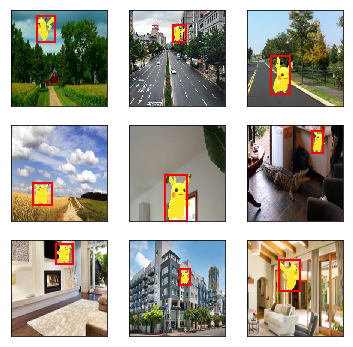

In [14]:
show_images(batch, nrows=3, ncols=3)

## 训练

In [15]:
import time 

ctx = mx.gpu(0)
net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1, 'wd': 5e-4})

for epoch in range(5):
    train_data.reset()
    obj_loss.reset()
    cls_loss.reset()
    box_loss.reset()
    
    tic = time.time()
    
    for i, batch in enumerate(train_data):
        data = batch.data[0].as_in_context(ctx)
        label = batch.label[0].as_in_context(ctx)
        
        with autograd.record():
            features = net(data) # extract features from body network
            output, cls_pred, score, xywh = yolov2_forward(features, num_classes=2, anchor_scales=scales)
            
            with autograd.pause(): 
                tid, tscore, tbox, sample_weight = yolov2_target(scores=score, labels=label, anchors=scales)
                
            loss1 = sce_loss(cls_pred, tid, sample_weight * class_weight)
            
            # condition: sample_weight > 0
            # if True: return the value in nd.ones_like(sample_weight) * positive_weight
            # if False: return the value in nd.ones_like(sample_weight) * negative_weight
            score_weight = nd.where(sample_weight > 0, nd.ones_like(sample_weight) * positive_weight,
                                   nd.ones_like(sample_weight) * negative_weight)
            
            loss2 = l1_loss(score, tscore, score_weight)
            loss3 = l1_loss(xywh, tbox, sample_weight * box_weight)
            
            loss = loss1 + loss2 + loss3
            
        loss.backward()
        trainer.step(batch_size)
        
        cls_loss.update(loss1)
        obj_loss.update(loss2)
        box_loss.update(loss3)
        
    print("[Epoch %d] %s, %.5f, %s, %.5f, %s, %.5f, time %.2f sec." % (
        epoch, *cls_loss.get(), *obj_loss.get(), *box_loss.get(), time.time() - tic))

[Epoch 0] classification_loss, 0.00132, objectness_loss, 0.05324, box_refine_loss, 0.00335, time 10.81 sec.
[Epoch 1] classification_loss, 0.00126, objectness_loss, 0.05103, box_refine_loss, 0.00309, time 9.36 sec.
[Epoch 2] classification_loss, 0.00121, objectness_loss, 0.04882, box_refine_loss, 0.00287, time 9.11 sec.
[Epoch 3] classification_loss, 0.00117, objectness_loss, 0.04667, box_refine_loss, 0.00266, time 9.28 sec.
[Epoch 4] classification_loss, 0.00112, objectness_loss, 0.04458, box_refine_loss, 0.00250, time 9.14 sec.


## 预处理和测试

In [20]:
def preprocess(fname):
    with open(fname, 'rb') as f:
        im = image.imdecode(f.read())
    # resize to data_shape 
    img = image.imresize(im, data_shape, data_shape)
    # minus rgb_mean, divide rgb_std
    img = (img.astype(np.float32) - rgb_mean) / rgb_std
    # reshape to (batch X channel X height X width)
    return img.transpose((2, 0, 1)).expand_dims(axis=0), img

def predict(X): 
    X = net(X)
    output, cls_prob, score, xywh = yolov2_forward(X, num_classes=2, anchor_scales=scales)
    return nd.contrib.box_nms(output.reshape((0, -1, 6)))

In [27]:
X, img = preprocess('pikachu.jpg')
out = predict(X.as_in_context(ctx))

In [28]:
print(out.shape)

(1, 512, 6)


In [29]:
out


[[[ 1.          0.46257254  0.          0.2415469   0.61754876
    0.74989974]
  [ 1.          0.4396819   0.2321576   0.38461193  0.45964354
    0.63589776]
  [ 1.          0.43745822  0.04292974  0.38275278  0.26829988
    0.60524654]
  ...
  [-1.         -1.         -1.         -1.         -1.
   -1.        ]
  [-1.         -1.         -1.         -1.         -1.
   -1.        ]
  [-1.         -1.         -1.         -1.         -1.
   -1.        ]]]
<NDArray 1x512x6 @gpu(0)>

## 显示结果

In [30]:
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt 
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = (8, 8)

colors = ['blue', 'green', 'red', 'black', 'magenta']

def display(im, out, threshold=0.5):
    plt.imshow(im.asnumpy())
    for row in out:
        row = row.asnumpy()
        class_id, score = int(row[0]), row[1]
        
        if class_id < 0 or score < threshold:
            continue
        
        print(score)
        
        color = colors[class_id % len(colors)]
        box = row[2:6] * np.array([im.shape[0], im.shape[1]] * 2) # height width height width 
        rect = box_to_rect(box, color, linewidth=2)
        plt.gca().add_patch(rect)
        
        text = class_name[class_id]
        plt.gca().text(box[0], box[1], '{:s}{:2f}'.format(text, score), 
                       bbox=dict(facecolor=color, alpha=0.5), fontsize=10, color="white")
        
    plt.show()

0.46257254


AttributeError: 'numpy.ndarray' object has no attribute 'asnumpy'

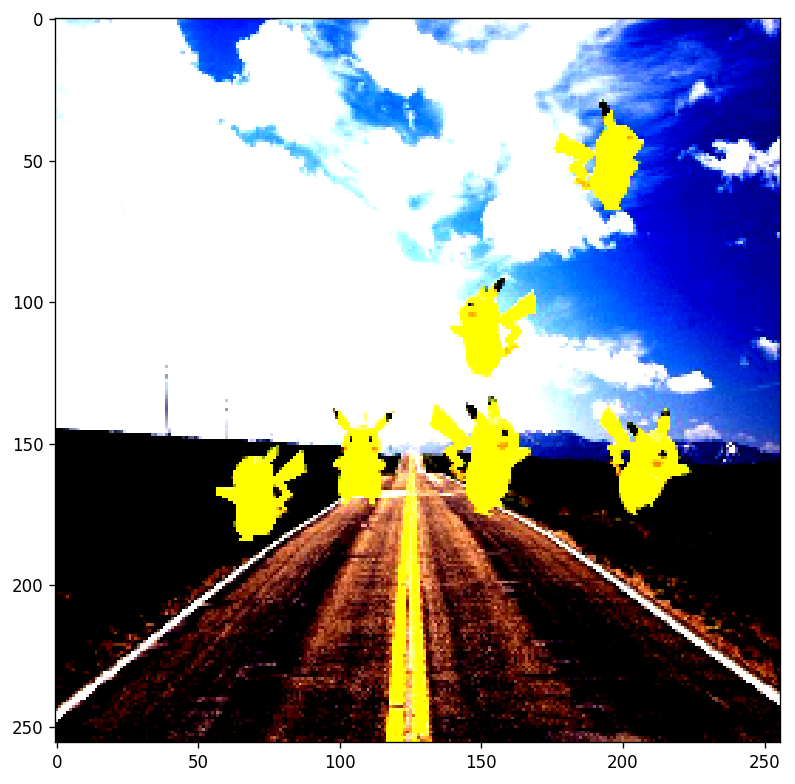

In [31]:
display(img, out[0], threshold=0.1)